# Connectome-constrained visual system model

**Authors:** Thomas Ka Chung Lam, Sibo Wang-Chen

**Note:** The code presented in this notebook has been simplified and restructured for display in a notebook format. A more complete and better structured implementation can be found in the [examples folder of the FlyGym repository on GitHub](https://github.com/NeLy-EPFL/flygym/tree/main/flygym/examples/).

**Summary**: In this tutorial, we will (1) simulate two flies in the same arena, and (2) integrate a connectome-constrained visual system model [(Lappalainen et al., 2023)](https://www.biorxiv.org/content/10.1101/2023.03.11.532232) into NeuroMechFly. Combining these, we will simulate a scenario where a stationary fly observes another fly walking in front of it and examine the responses of different neurons in the visual system.

## Simulation with multiple flies

In the previous tutorial, we have used `HybridTurningController` to control the walking fly at a high level of abstraction — instead of specifying joint movements, we provide a 2D descending drive and rely on the underlying CPG network and sensory feedback-based correction mechanism to compute the appropriate joint actions. Details of this controller was covered in [this tutorial](https://neuromechfly.org/tutorials/turning.html). One limitation of this design decision is that the controller is implemented at the level of the Simulation (recall that `HybridTurningController` extends the `Simulation` class). Therefore, it is difficult to model multiple flies, each driven by a hybrid turning controller, in a single simulation.

To overcome this limitation, we can implement the core logic of the hybrid turning controller at the level of the Fly instead (see [API reference](https://neuromechfly.org/api_ref/examples/locomotion.html#hybrid-turning-fly)). Because we can have multiple Fly objects in the same Simulation, this approach allows us to separately control multiple "`HybridTurningFly`" instance. Let's spawn two flies, a target fly and an observer fly that looks at the target fly perpendicular to the target fly's heading direction:

In [1]:
from pathlib import Path

output_dir = Path("outputs/advanced_vision/")
output_dir.mkdir(parents=True, exist_ok=True)

In [2]:
import numpy as np
from flygym import Camera, Simulation
from flygym.examples.locomotion import HybridTurningFly

timestep = 1e-4
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

target_fly = HybridTurningFly(
    name="target",
    enable_adhesion=True,
    draw_adhesion=False,
    contact_sensor_placements=contact_sensor_placements,
    seed=0,
    draw_corrections=True,
    timestep=timestep,
    spawn_pos=(3, 3, 0.5),
    spawn_orientation=(0, 0, 0),
)

observer_fly = HybridTurningFly(
    name="observer",
    enable_adhesion=True,
    draw_adhesion=False,
    enable_vision=True,
    contact_sensor_placements=contact_sensor_placements,
    seed=0,
    draw_corrections=True,
    timestep=timestep,
    spawn_pos=(0, 0, 0.5),
    spawn_orientation=(0, 0, np.pi / 2),
    # setting head_stabilization_model to "thorax" will make actuate
    # neck joints according to actual thorax rotations (i.e., using ideal
    # head stabilization signals)
    head_stabilization_model="thorax",
)

cam = Camera(
    fly=observer_fly,
    camera_id="Animat/camera_top_zoomout",
)

sim = Simulation(
    flies=[observer_fly, target_fly],
    cameras=[cam],
    timestep=timestep,
)

We can control the movement of the flies separately by passing two sets of actions, indexed by the fly names. In this example, we will keep the observer fly stationary and make the target fly walk straight:

In [3]:
from tqdm import trange

run_time = 0.5  # sec

obs, info = sim.reset(seed=0)
for i in trange(int(run_time / timestep)):
    obs, _, _, _, info = sim.step(
        {
            "observer": np.zeros(2),  # stand still
            "target": np.ones(2),  # walk forward
        }
    )
    sim.render()

cam.save_video(output_dir / "two_flies_walking.mp4")

/home/sibwang/anaconda3/envs/flygym312/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
100%|██████████| 5000/5000 [00:53<00:00, 93.26it/s] 


## Interfacing NeuroMechFly with a connectome-constrained vision model

So far, we have implemented various abstract, algorithmic controllers to control a diverse range of behaviors in NeuroMechFly. Ultimately, to gain insights into the real workings of the biological controller, one would ideally build a controller with artificial neurons that can be mapped to neuron subtypes in the real fly nervous system. This can, in principle, be achieved by leveraging newly available brain and VNC connectomics datasets (see the [FlyWire](https://flywire.ai/) project for the brain, and the [FANC](https://connectomics.hms.harvard.edu/project1) and [MANC](https://www.janelia.org/project-team/flyem/manc-connectome) projects for the VNC).

To illustrate how this might be accomplished, we will interface NeuroMechFly a recently established connectome-constrained neural network model ([Lappalainen et al., 2023](https://www.biorxiv.org/content/10.1101/2023.03.11.532232); [code](https://github.com/TuragaLab/flyvis)). This study has constructed an artificial neural network (ANN) representing the retina, lamina, medula, lobula plate, and lobula of the fly visual system (see figure below). The connectivity in this network is informed by the connectome and, unlike typical ANNs, models biologically meaningful variables such as voltage.

<p align="center">
<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/advanced_vision/lappalainen_model_schematic.png?raw=true" alt="lappalainen_model_schematic.png" width="500"/>
</p>

_Image from Lappalainen et al., 2023._

We will pass the visual experience of the simulated fly as inputs to this pretrained model and simulate the activities of real neurons. For this purpose, we have implemented a `RealisticVisionFly` class that extends `HybridTurningFly`. Let's initialize the simulation but replace the observer fly with an instance of `RealisticVisionFly`:

In [4]:
from flygym.examples.vision import RealisticVisionFly

target_fly = HybridTurningFly(
    name="target",
    enable_adhesion=True,
    draw_adhesion=False,
    contact_sensor_placements=contact_sensor_placements,
    seed=0,
    draw_corrections=True,
    timestep=timestep,
    spawn_pos=(3, 3, 0.5),
    spawn_orientation=(0, 0, 0),
)

observer_fly = RealisticVisionFly(
    name="observer",
    spawn_pos=(0, 0, 0.5),
    spawn_orientation=(0, 0, np.pi / 2),
    contact_sensor_placements=contact_sensor_placements,
    head_stabilization_model="thorax",
)

cam = Camera(
    fly=observer_fly,
    camera_id="Animat/camera_top_zoomout",
)

sim = Simulation(
    flies=[observer_fly, target_fly],
    cameras=[cam],
    timestep=timestep,
)

/home/sibwang/anaconda3/envs/flygym312/lib/python3.12/site-packages/torch/__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


We can implement the main simulation loop as follows:

In [5]:
obs, info = sim.reset(seed=0)
viz_data_all = []
obs_hist = []
info_hist = []

for i in trange(int(run_time / timestep)):
    obs, _, _, _, info = sim.step(
        {
            "observer": np.zeros(2),  # stand still
            "target": np.ones(2),  # walk forward
        }
    )
    obs_hist.append(obs)
    info_hist.append(info)

    rendered_img = sim.render()[0]

    if rendered_img is not None:
        viz_data = {
            "rendered_image": rendered_img,
            "vision_observation": obs["observer"]["vision"],  # raw visual observation
            "nn_activities": info["observer"]["nn_activities"],  # neural activities
        }
        viz_data_all.append(viz_data)

100%|██████████| 5000/5000 [09:20<00:00,  8.92it/s]


From the "info" dictionary, we can get the "nn_activities" entry, which is an extended dictionary containing the current activities of all neurons simulated in the network. For a complete definition of what the simulation returns in the observation and "info" dictionary, please refer to the [MDP Task Specification page](https://neuromechfly.org/api_ref/mdp_specs.html) of the API reference.

In [6]:
print(info["observer"]["nn_activities"].keys())

dict_keys(['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'L1', 'L2', 'L3', 'L4', 'L5', 'Lawf1', 'Lawf2', 'Am', 'C2', 'C3', 'CT1(Lo1)', 'CT1(M10)', 'Mi1', 'Mi2', 'Mi3', 'Mi4', 'Mi9', 'Mi10', 'Mi11', 'Mi12', 'Mi13', 'Mi14', 'Mi15', 'T1', 'T2', 'T2a', 'T3', 'T4a', 'T4b', 'T4c', 'T4d', 'T5a', 'T5b', 'T5c', 'T5d', 'Tm1', 'Tm2', 'Tm3', 'Tm4', 'Tm5Y', 'Tm5a', 'Tm5b', 'Tm5c', 'Tm9', 'Tm16', 'Tm20', 'Tm28', 'Tm30', 'TmY3', 'TmY4', 'TmY5a', 'TmY9', 'TmY10', 'TmY13', 'TmY14', 'TmY15', 'TmY18'])


As an example, we can access the activities of the T4a/b/c/d neurons, which are known for encoding optical flow:

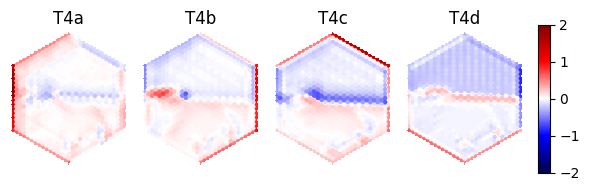

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    1, 5, figsize=(6, 2), width_ratios=[2, 2, 2, 2, 0.2], tight_layout=True
)

for i, cell in enumerate(["T4a", "T4b", "T4c", "T4d"]):
    ax = axs[i]

    # Take the cell activities of the right eye (index 1)
    cell_activities = info["observer"]["nn_activities"][cell][1]
    cell_activities = observer_fly.retina_mapper.flyvis_to_flygym(cell_activities)

    # Convert the values of 721 cells to a 2D image
    viz_img = observer_fly.retina.hex_pxls_to_human_readable(cell_activities)
    viz_img[observer_fly.retina.ommatidia_id_map == 0] = np.nan
    imshow_obj = ax.imshow(viz_img, cmap="seismic", vmin=-2, vmax=2)
    ax.axis("off")
    ax.set_title(cell)

cbar = plt.colorbar(
    imshow_obj,
    cax=axs[4],
)
fig.savefig(output_dir / "retina_activities.png")

We can also extract the whole time series of cell activities:

In [11]:
all_cell_activities = np.array(
    [obs["observer"]["nn_activities_arr"] for obs in obs_hist]
)
print(all_cell_activities.shape)

(5000, 2, 45669)


... where the shape is (num_timesteps, num_eyes=2, num_cells_per_eye=45669).

To visualize this block data better, we have implemented a `visualize_vision` function:

In [12]:
from flygym.examples.vision.viz import visualize_vision

plt.ioff()  # turn off interactive display of image
visualize_vision(
    video_path=output_dir / "two_flies_walking_vision.mp4",
    retina=observer_fly.retina,
    retina_mapper=observer_fly.retina_mapper,
    viz_data_all=viz_data_all,
    fps=cam.fps,
)

 99%|█████████▊| 74/75 [01:26<00:01,  1.21s/it]